# Analyzing NYC High School Data

In this project, we will be looking at NYC high school data which can be found [here](https://data.cityofnewyork.us/browse?category=Education).

In particular, we will be looking into the relationships between demographics and SAT scores. For this investigation, we are using the latest released data at the time of this project which are the following:
- AP (Advanced Placement) scores from 2010
- Graduation data from 2006
- Demographic data of 2011-2012
We will assume for simplicity and due to the limitations of the data that no significant change has occurred between those time points.

At the end, we will be looking into the following:
- Best schools in least expensive neighborhoods
- Differences between parent, teacher, and student responses to the surveys
- Assigning a score to schools based on SAT scores and other attributes

## Reading in the Data

First, we'll read in the data and combine it into something meaningful to then work with.

### Reading in the Demographic Data

First, let's take a look at the demographic data.

In [492]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

# Read in the csv files into dictionaries
for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [493]:
for d in data.items():
    print(d[0])
    print(d[1].columns)

ap_2010
Index(['DBN', 'SchoolName', 'AP Test Takers ', 'Total Exams Taken',
       'Number of Exams with scores 3 4 or 5'],
      dtype='object')
class_size
Index(['CSD', 'BOROUGH', 'SCHOOL CODE', 'SCHOOL NAME', 'GRADE ',
       'PROGRAM TYPE', 'CORE SUBJECT (MS CORE and 9-12 ONLY)',
       'CORE COURSE (MS CORE and 9-12 ONLY)', 'SERVICE CATEGORY(K-9* ONLY)',
       'NUMBER OF STUDENTS / SEATS FILLED', 'NUMBER OF SECTIONS',
       'AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS',
       'DATA SOURCE', 'SCHOOLWIDE PUPIL-TEACHER RATIO'],
      dtype='object')
demographics
Index(['DBN', 'Name', 'schoolyear', 'fl_percent', 'frl_percent',
       'total_enrollment', 'prek', 'k', 'grade1', 'grade2', 'grade3', 'grade4',
       'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11',
       'grade12', 'ell_num', 'ell_percent', 'sped_num', 'sped_percent',
       'ctt_num', 'selfcontained_num', 'asian_num', 'asian_per', 'black_num',
       'black_per', 'hispa

### Read in the Surveys

Next, let's read in the surveys to add to the data dictionary.

In [494]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

In [495]:
# Fields of interest
survey.rename({'dbn':'DBN'},axis=1,inplace=True)
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data['survey'] = survey.copy()

## Prepping the Data

Now that we have read in the data, let's prepare it so that we can use it for analysis later.

### Add DBN Columns Where Needed

DBN stands for district borough number. We should add this to the *class_size.csv* dataframe to line up schools. The CSD is the community school district number. To create the DBN, we create a padded CSD number and then concatenate the CSD with that.

In [496]:
data["hs_directory"].rename({'dbn':'DBN'},axis=1,inplace=True)

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:  # CSDs are maximum 2 digits
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert Columns to Numeric

Now, we should convert values where possible to numeric types.

In [497]:
# Columns of interest
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Total score adding all 3 scroes
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Getting geographic location
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Apply functions
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Cast to numeric types
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense the Datasets

Here, we will drop unnecessary rows by filtering for the criteria that gives general high school data for the latest year possible per data set.

In [498]:
# Class size for high school and general education program
class_size = data["class_size"]
class_size = class_size[(class_size["GRADE "] == "09-12") & (class_size["PROGRAM TYPE"] == "GEN ED")]
class_size = class_size.groupby("DBN").agg(numpy.mean).reset_index()
data["class_size"] = class_size

# Demographics from 2011-2012
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# The whole graduation cohort of 2006
data["graduation"] = data["graduation"][(data["graduation"]["Cohort"] == "2006") 
                                        & (data["graduation"]["Demographic"] == "Total Cohort")
                                       ]

### Converting AP scores to Numeric

Now, we'll convert the AP scores to a numeric type.

In [499]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the Datasets

Next, we'll combine all the relevant datasets using the DBN. Before we merge, let's get rid of any duplicates.

In [500]:
data['ap_2010'] = data['ap_2010'].drop_duplicates(subset=['DBN'])

In [501]:
# These data sets are of interest
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# The rest of the data sets
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

### Adding a School District Column for Mapping

Analyzing school districts as a group might be of interest as well. We will add that below.

In [502]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analyzing the Data

Now that the data is prepped, we will look at a few analyses.

### Finding Correlations

First, we'll look at correlations between SAT score and values in the combined data set.

<AxesSubplot:>

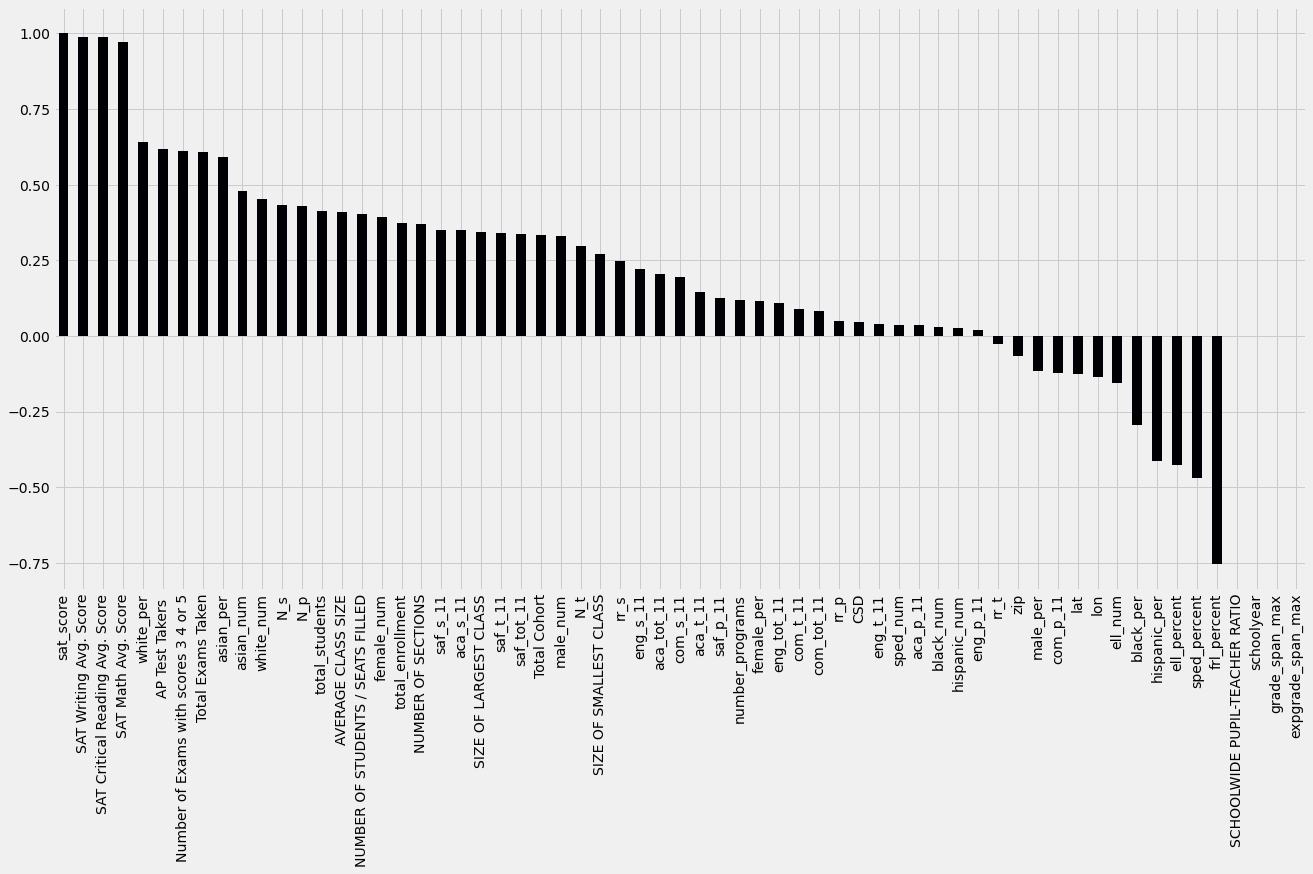

In [503]:
%matplotlib inline

import matplotlib
matplotlib.style.use('fivethirtyeight')

correlations = combined.corr()['sat_score'].sort_values(ascending=False)
correlations.plot.bar(y='sat_score',figsize=(20,10),colormap='magma')

Here we see that the highest positive correlations (sans the sat_score itself and its direct components) are the following:
1. white_per
2. AP Test Takers
3. Number of Exams with scores 3 4 or 5
4. Total Exams Taken
5. asian_per

We see that the highest negative correlations are (sans the NaN) are the following:
1. frl_percent (free/reduced lunch)
2. sped_percent (special education)
3. ell_percent (English language learners)
4. hispanic_per
5. black_per

For the positive correlations, the racial demographic makeup tends to be from richer neighborhoods with more funded schools. The AP exams are also correlated with performance on the SAT (since they are both standardized tests).

For the negative correlations, the racial demographic makeup tends to be from poorer neighborhoods with less funded schools. Also, students that are in special education or are learning English language tend not to do well with a standardized exam such as the SAT.

### Plotting Survey Correlations

First, we'll look specifically at the NYC School Survey data, we will see if there are any correlations specifically from that.

In [504]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

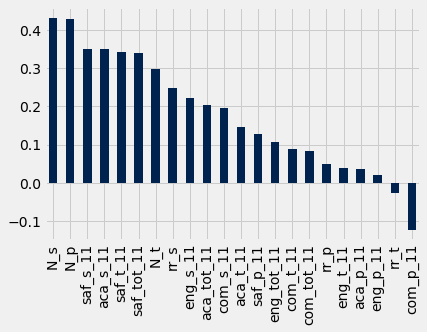

In [505]:
correlations[survey_fields].sort_values(ascending=False).plot.bar(colormap='cividis')

We see a few of the following observations:
- There are high correlations between N_s, N_t, N_p and sat_score. This makes sense since the columns are correlated with total_enrollment and the size of the school and its resources.
- There is also a high correlation with student response rate (rr_s) and sat_score due to students who are doing well academically may also be more likely to fill out surveys.
- Safety (saf_t_11 and saf_s_11) also has a high correlation due to teaching or learning in unsafe environments affecting academic outcomes.
- Students perceiving academic standards (aca_s_11) correlates with sat_score, but interestingly teacher perceptions doesn't correlate with sat_score.

### Safety and SAT Scores

Second, we will be looking at safety scores and their effect on SAT scores.

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

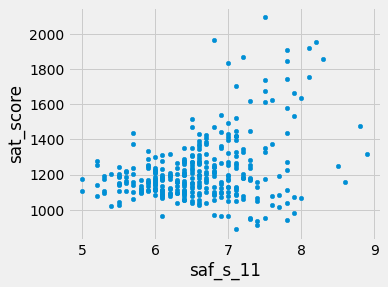

In [506]:
combined.plot.scatter('saf_s_11','sat_score',figsize=(5,4))

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

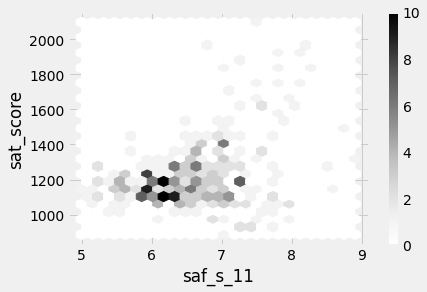

In [507]:
combined.plot.hexbin(x='saf_s_11',y='sat_score', gridsize=25, sharex=False, figsize=(6,4),colormap='Greys')

You can see in the above plots that the correlation between safety and sat_score isn't too strong.

Below, we will look at it by borough:

In [508]:
boro_safety = combined.groupby("boro").agg(numpy.mean)[['saf_s_11','sat_score']]
print(boro_safety)

               saf_s_11    sat_score
boro                                
Bronx          6.606522  1153.057471
Brooklyn       6.370755  1178.840000
Manhattan      6.828736  1285.461538
Queens         6.721875  1292.118644
Staten Island  6.530000  1382.500000


While Manhattan and Queens are the safest, they don't have the highest average SAT score (which one of the unsafest - Staten Island - has the highest). Brooklyn which is the most unsafe also has one of the lowest average SAT scores.

### Race and SAT Scores

Third, we will be looking at racial differences and their effect on SAT scores.

<AxesSubplot:>

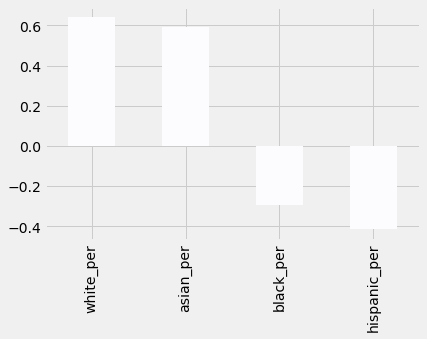

In [509]:
correlations[['white_per','asian_per','black_per','hispanic_per']].plot.bar(colormap='Purples')

The positive and negative correlations here may be indicative of a lack of resources at schools with a higher percentage of the respective races.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

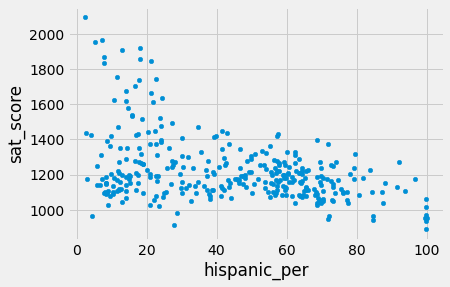

In [510]:
combined.plot.scatter('hispanic_per','sat_score')

We can see when plotting a scatter of the two variables that there doesn't really seem to be a significant trend after 30% Hispanic. Let's take a look at some of the highest Hispanic percentages below.

In [511]:
print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
81      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
88     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
124                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
140                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
175     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
252                            MULTICULTURAL HIGH SCHOOL
285               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Upon further research into the above, it seems that these schools seem to be geared towards recent immigrants and students still learning English which could indicate why the SAT scores are lower.

In [512]:
print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
150                         BRONX HIGH SCHOOL OF SCIENCE
186                       BROOKLYN TECHNICAL HIGH SCHOOL
326    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
355                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools seem to be specialized science and technology schools with entrance exams. While it doesn't explain the low hispanic percentage, it does explain why the students tend to do better on the SAT.

### Gender and SAT Scores

Fourthly, we will be looking at gender differences and their effect on SAT scores.

<AxesSubplot:>

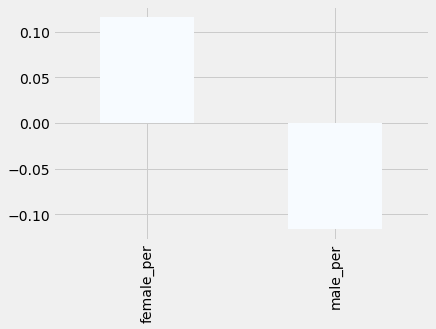

In [513]:
correlations[['female_per','male_per']].plot.bar(colormap='Blues')

While neither correlation is strong, there are slight differences across gender. We'll look into the female percentage below.

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

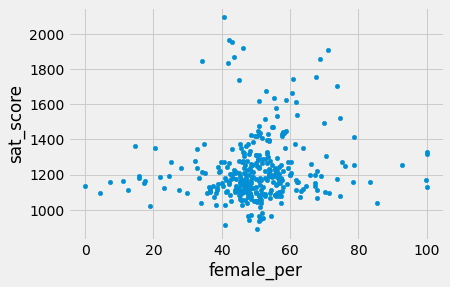

In [514]:
combined.plot.scatter('female_per', 'sat_score')

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

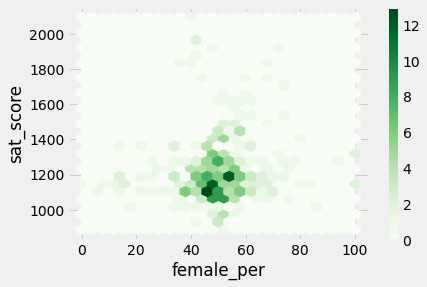

In [515]:
combined.plot.hexbin(x='female_per',y='sat_score', gridsize=25, sharex=False, figsize=(6,4),colormap='Greens')

No high correlation at all, although there are a cluster of schools with 40-80% female with high SAT scores. If we take a look at some of those we see the following:

In [516]:
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
301                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These selective liberal arts schools above have high academic standards.

### AP Scores and SAT Scores

Fifthly, we will be looking at the percentage of AP test takers and effects on SAT Scores.

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

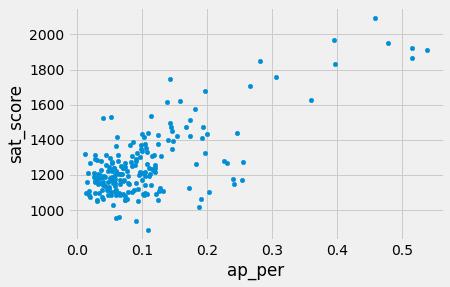

In [517]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

<AxesSubplot:xlabel='ap_per', ylabel='sat_score'>

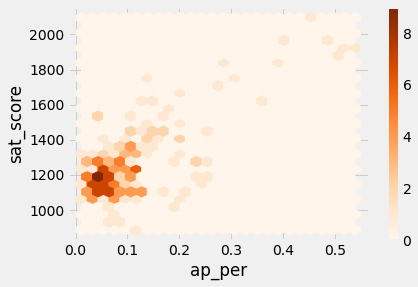

In [518]:
combined.plot.hexbin(x='ap_per',y='sat_score', gridsize=25, sharex=False, figsize=(6,4),colormap='Oranges')

While there is a relationship with AP exam takers and SAT scores, it is not strong since there are low average SAT scores when even most of the students take AP exams.

### Class Size and SAT Scores

Sixthly, we will be looking at the average class size and effects on SAT Scores.

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

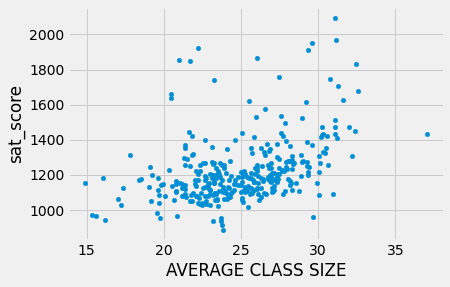

In [519]:
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score')

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

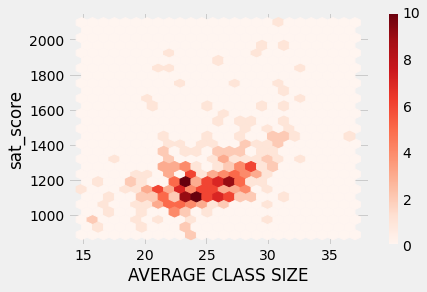

In [520]:
combined.plot.hexbin(x='AVERAGE CLASS SIZE',y='sat_score', gridsize=25, sharex=False, figsize=(6,4),colormap='Reds')

We see a somewhat weak correlation between class size and SAT score.

## Figuring Out Which Neighborhoods Have the Best Schools

For this next part, we will be looking at schools with the best SAT scores that are also in the cheapest neighborhoods (borough). Let's import and work with a NYC property sales data set found [here](https://www.kaggle.com/new-york-city/nyc-property-sales).

In [521]:
sales = pd.read_csv("schools/nyc-rolling-sales.csv")

In [522]:
sales.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

From the above columns, we will use borough, residential units (to confirm that it is residential and thus applicable to living), and sale price to then compare to SAT scores. Let's take a look at the data first to clean it if necessary.

### Cleaning the Sales Data

First, we'll take a look at the columns of relevance and clean if necessary.

In [523]:
sales = sales[['BOROUGH','RESIDENTIAL UNITS','SALE PRICE']]

sales.head()

,BOROUGH,RESIDENTIAL UNITS,SALE PRICE
0,1,5,6625000
1,1,28,-
2,1,16,-
3,1,10,3936272
4,1,6,8000000


We'll have to convert borough to the relevant neighborhood string, filter out anything with 0 residential units, and drop any null sale prices that indicate the property was passed down.

The conversions for borough are: Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)

In [524]:
conversion_dict = {1:'Manhattan',2:'Bronx',3:'Brooklyn',4:'Queens',5:'Staten Island'}
sales['BOROUGH'] = sales['BOROUGH'].replace(conversion_dict)
sales['BOROUGH'].value_counts(dropna=False)

Queens           26736
Brooklyn         24047
Manhattan        18306
Staten Island     8410
Bronx             7049
Name: BOROUGH, dtype: int64

In [525]:
sales['RESIDENTIAL UNITS'] = sales['RESIDENTIAL UNITS'].replace(0,numpy.nan)
sales = sales.dropna(subset=['RESIDENTIAL UNITS'])
sales['RESIDENTIAL UNITS'].value_counts(dropna=False)

1.0      34722
2.0      16049
3.0       4608
4.0       1346
6.0        787
         ...  
179.0        1
75.0         1
193.0        1
153.0        1
128.0        1
Name: RESIDENTIAL UNITS, Length: 175, dtype: int64

In [526]:
sales['SALE PRICE'].value_counts(dropna=False)

 -         10751
0           7950
10           700
600000       336
650000       323
           ...  
1338998        1
342732         1
388487         1
5992945        1
408092         1
Name: SALE PRICE, Length: 7749, dtype: int64

In [527]:
sales['SALE PRICE'] = sales['SALE PRICE'].replace('-',numpy.nan,regex=True)
sales['SALE PRICE'] = pd.to_numeric(sales['SALE PRICE'])
sales['SALE PRICE'] = sales['SALE PRICE'].replace(0,numpy.nan)
sales = sales.dropna(subset=['SALE PRICE'])
sales['SALE PRICE'].value_counts().sort_index()

1.0            102
3.0              1
8.0              1
10.0           700
19.0             1
              ... 
172500000.0      1
182391612.0      1
212500000.0      1
239114603.0      1
620000000.0      1
Name: SALE PRICE, Length: 7747, dtype: int64

As we can see above with the low sale prices, we should remove low outliers.

In [528]:
grouped_sales = sales.groupby('BOROUGH')
grouped_sales['SALE PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
Bronx,3789.0,7.671524e+05,2.662321e+06,1.0,300000.0,447000.0,591000.00,78137536.0
Brooklyn,12044.0,1.191660e+06,2.491888e+06,1.0,540000.0,843564.5,1315000.00,154250000.0
Manhattan,6668.0,3.824023e+06,1.093909e+07,1.0,980000.0,1768375.0,3780405.25,620000000.0
Queens,12927.0,7.441491e+05,1.756094e+06,1.0,425000.0,615000.0,850000.00,125000000.0
Staten Island,5636.0,4.922654e+05,3.549562e+05,1.0,340000.0,470000.0,600000.00,11900000.0


We will use the 25th quantile of the Bronx as the low point for all values.

In [529]:
sales = sales[sales['SALE PRICE'] >= 300000]
boro_sales = boro_safety.merge(sales, left_on='boro', right_on='BOROUGH', how='inner')

In [530]:
grouped_sales = boro_sales.groupby('BOROUGH').agg(numpy.mean)[['sat_score','SALE PRICE']]
print(grouped_sales.head())

                 sat_score    SALE PRICE
BOROUGH                                 
Bronx          1153.057471  9.616035e+05
Brooklyn       1178.840000  1.292504e+06
Manhattan      1285.461538  3.916210e+06
Queens         1292.118644  8.227215e+05
Staten Island  1382.500000  5.598840e+05


Above, we can see that the highest average sale price neighborhood of Manhattan does not result in the highest SAT scores. The cheapest average sale price neighborhood of Staten Island also has the highest SAT scores.

## Investigating Parent, Teacher, and Student Responses to the Survey

For fun, we can also look at the differing response types by parent, teacher, and student.

In [531]:
# _s = student, _t = teacher, _p = parent
survey_data = data['survey'].select_dtypes(include=numpy.number).mean().sort_index()
print(survey_data)

N_p           274.548939
N_s           416.485521
N_t            37.104118
aca_p_11        8.134021
aca_s_11        7.630502
aca_t_11        7.749059
aca_tot_11      7.897474
com_p_11        7.926946
com_s_11        6.319788
com_t_11        6.854706
com_tot_11      7.192127
eng_p_11        7.825649
eng_s_11        6.954344
eng_t_11        7.240824
eng_tot_11      7.435958
rr_p           55.310223
rr_s           84.109510
rr_t           82.623972
saf_p_11        8.538443
saf_s_11        6.769595
saf_t_11        7.449294
saf_tot_11      7.774736
dtype: float64


<AxesSubplot:>

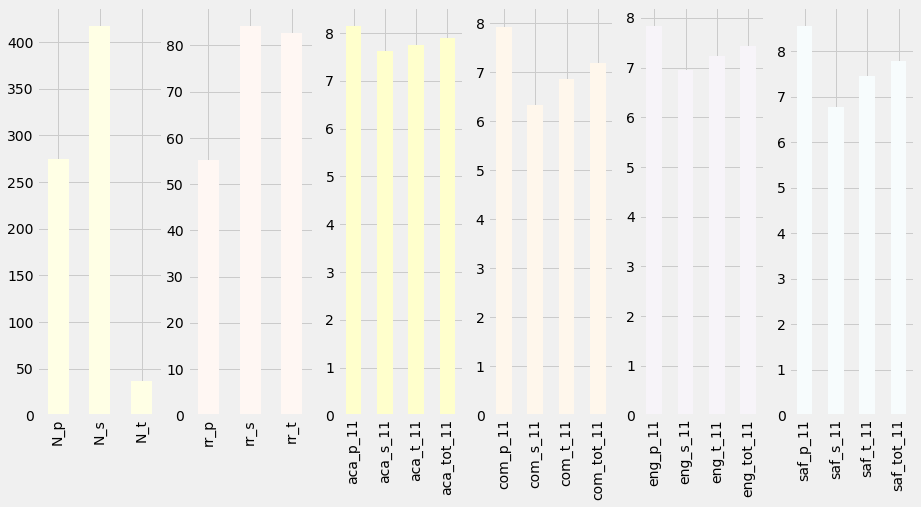

In [532]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(14,7))

survey_data.iloc[0:3].plot(kind='bar', ax=axes[0], colormap='YlOrBr')
survey_data.iloc[15:18].plot(kind='bar', ax=axes[1], colormap='RdPu')
survey_data.iloc[3:7].plot(kind='bar', ax=axes[2], colormap='YlOrRd')
survey_data.iloc[7:11].plot(kind='bar', ax=axes[3], colormap='OrRd')
survey_data.iloc[11:15].plot(kind='bar', ax=axes[4], colormap='PuRd')
survey_data.iloc[18:22].plot(kind='bar', ax=axes[5], colormap='BuPu')

Some things of interest from the above plot. Looking at the first subplot, the number of teachers responding was on average pretty low, but this makes sense due to the number of teachers per school.

Looking at the second subplot, the rate of response of parents is significantly lower than that of students and teachers. This makes sense because parents may not have to comply with taking the survey.

For the rest of the subplots, it seems that students tend to rate values lowest with teachers in the middle and parents the highest. This is interesting because students seem to be more pessimistic while parents who may not know much tend to rate responses as higher.

## Scoring Schools

Finally, with all this analysis, we should look at assigning scores to each school based on a variety of factors such as SAT score. For simplicity, we will use attributes that we have already investigated in this analysis project. We will also be normalizing all the attributes that we use to a 0 to 1 point scale.

There are a variety of factors that can come into play such as diversity or number of programs. To minimize bias in scoring criteria, we will use common objective attributes such as average class size, SAT score average, passing AP exams, and the total subjective survey data.

In [533]:
combined_attributes = [
    'AVERAGE CLASS SIZE',
    'sat_score',
    'Number of Exams with scores 3 4 or 5',
    'aca_tot_11',
    'com_tot_11',
    'eng_tot_11',
    'saf_tot_11'
]

### Feature Creation

Let's make averages of some of the attributes of interest. In particular, we will average the number of passing AP exams per number of tests taken.

In [534]:
def non_null(col_1, col_2):
    if pd.isnull(col_1):
        if not pd.isnull(col_2):
            return 0
    else:
        return col_1

# Address null values in the Number of Exams with scores 3 4 or 5 so that NaN turns into 0 if there are any AP Test Takers
combined['Number of Exams with scores 3 4 or 5'] = combined.apply(lambda x: non_null(x['Number of Exams with scores 3 4 or 5'], x['Total Exams Taken']),axis=1)

Now, we will create an average number of passed exams.

In [535]:
combined['ap_passing_avg'] = combined['Number of Exams with scores 3 4 or 5'] / combined['Total Exams Taken']

In [536]:
combined_attributes[2] = 'ap_passing_avg'

normalized = combined.copy()
normalized[combined_attributes] = (normalized[combined_attributes] - normalized[combined_attributes].min())/(normalized[combined_attributes].max()-normalized[combined_attributes].min())

Now that we have normalized the columns, we should account for certain aspects. For example, a higher average class size is seen as a negative. We should get the complement for that column.

In [537]:
normalized['AVERAGE CLASS SIZE'] = 1 - normalized['AVERAGE CLASS SIZE']

In [538]:
normalized[combined_attributes].describe()

,AVERAGE CLASS SIZE,sat_score,ap_passing_avg,aca_tot_11,com_tot_11,eng_tot_11,saf_tot_11
count,362.000000,334.000000,208.000000,362.000000,362.000000,362.000000,362.000000
mean,0.452633,0.278025,0.281590,0.561957,0.623465,0.550844,0.547401
std,0.131727,0.153629,0.269241,0.147293,0.154289,0.144347,0.143053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.365018,0.183002,0.000000,0.464286,0.527778,0.459459,0.454545
50%,0.447386,0.242763,0.250000,0.571429,0.611111,0.540541,0.545455
75%,0.532171,0.318238,0.472542,0.657143,0.722222,0.648649,0.636364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now that we have normalized all the data, we can now average them. To be able to compare schools without letting the other columns have an unbalanced influence, we will replace null values with the average of the column.

In [539]:
normalized[combined_attributes].mean(numeric_only=True)

AVERAGE CLASS SIZE    0.452633
sat_score             0.278025
ap_passing_avg        0.281590
aca_tot_11            0.561957
com_tot_11            0.623465
eng_tot_11            0.550844
saf_tot_11            0.547401
dtype: float64

In [540]:
normalized = normalized.fillna(normalized.mean(numeric_only=True))

In [541]:
normalized[combined_attributes].describe()

,AVERAGE CLASS SIZE,sat_score,ap_passing_avg,aca_tot_11,com_tot_11,eng_tot_11,saf_tot_11
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,0.452633,0.278025,0.281590,0.561957,0.623465,0.550844,0.547401
std,0.131727,0.147551,0.203879,0.147293,0.154289,0.144347,0.143053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.365018,0.186518,0.200781,0.464286,0.527778,0.459459,0.454545
50%,0.447386,0.252688,0.281590,0.571429,0.611111,0.540541,0.545455
75%,0.532171,0.312655,0.297690,0.657143,0.722222,0.648649,0.636364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now, we will average each score and generate a score for each school.

In [545]:
normalized['Score'] = normalized[combined_attributes].mean(axis=1, numeric_only=True)

In [548]:
normalized[['SCHOOL NAME', 'boro', 'Score']].sort_values(by='Score',ascending=False).head()

,SCHOOL NAME,boro,Score
154,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,Bronx,0.800211
355,STATEN ISLAND TECHNICAL HIGH SCHOOL,Staten Island,0.786190
360,ALL CITY LEADERSHIP SECONDARY SCHOOL,Brooklyn,0.723657
5,BARD HIGH SCHOOL EARLY COLLEGE,Manhattan,0.721823
26,ELEANOR ROOSEVELT HIGH SCHOOL,Manhattan,0.710707


In [549]:
normalized[['SCHOOL NAME', 'boro', 'Score']].sort_values(by='Score').head()

,SCHOOL NAME,boro,Score
221,THE BROOKLYN ACADEMY OF GLOBAL FINANCE,Brooklyn,0.162140
314,AUGUST MARTIN HIGH SCHOOL,Queens,0.219362
305,MARTIN VAN BUREN HIGH SCHOOL,Queens,0.221252
75,URBAN ASSEMBLY SCHOOL FOR THE PERFORMING ARTS,Manhattan,0.245159
255,BROOKLYN LAB SCHOOL,Brooklyn,0.265990


We have now generated scores for all schools and have displayed the top 5 and bottom 5.

## Conclusion

After cleaning and merging the data, we looked into a variety of demographic factors that affect SAT scores at different schools in NYC.

To recap a summary that is further detailed above:

Here we see that the highest positive correlations (sans the sat_score itself and its direct components) are the following:

1. white_per
2. AP Test Takers
3. Number of Exams with scores 3 4 or 5
4. Total Exams Taken
5. asian_per

We see that the highest negative correlations are (sans the NaN) are the following:

1. frl_percent (free/reduced lunch)
2. sped_percent (special education)
3. ell_percent (English language learners)
4. hispanic_per
5. black_per

We noted that class size did not have a strong correlation with SAT score.

We saw that the best schools were in Staten Island which also turned out to be the cheapest based on average sale price.

We observed that students tended to rate surveys lower than their teachers and parents.

Finally, we generated scores for schools based on AP, SAT, class size, and survey scores.